In [107]:
# Comparing RO to INS data

import sys
sys.path.append("/Users/roberto/code/robust-me-scripts/scripts")
sys.path.append("/Users/roberto/code/robust-me-scripts/scripts/config")
from figs import plot
import motion

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
import os
from numpy import *

import module
import settings

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.titlepad'] = 20
plt.rcParams['axes.grid'] = True
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 16 # was 28

# text
plt.rc("font", family=settings.FONT_FAMILY)

module.set_sys_paths()

from mrg.logging import MonolithicDecoder
from mrg.adaptors.transform import PbSerialisedTransformToPython
from mrg.transform.conversions import se3_to_components, build_se3_transform

import numpy as np
from config.data import *

colour_ro = u'#d62728' #red
colour_spline = u'#1f77b4' #blue
colour_aux_1 = u'#ff7f0e' #orange
colour_aux_2 = u'#2ca02c' #green
colour_ins = 'black' #black

In [108]:
dataset_path = "/tmp/"
INS_relative_poses_path = dataset_path+"flattened_novatel_generated_poses.monolithic"

# INS - open monolithic and iterate frames
print("reading INS_relative_poses_path: " + INS_relative_poses_path)
monolithic_decoder = MonolithicDecoder(
    INS_relative_poses_path)

# iterate mono
INS_se3s = []
INS_timestamps = []

for pb_serialised_transform, _, _ in monolithic_decoder:
    # adapt
    serialised_transform = PbSerialisedTransformToPython(
        pb_serialised_transform)
    INS_se3s.append(serialised_transform[0])
    INS_timestamps.append(serialised_transform[1])
         
print("\nFinished importing.")

reading INS_relative_poses_path: /tmp/flattened_novatel_generated_poses.monolithic
importing  protobuf.transform.pbSerialisedTransform_pb2

Finished importing.


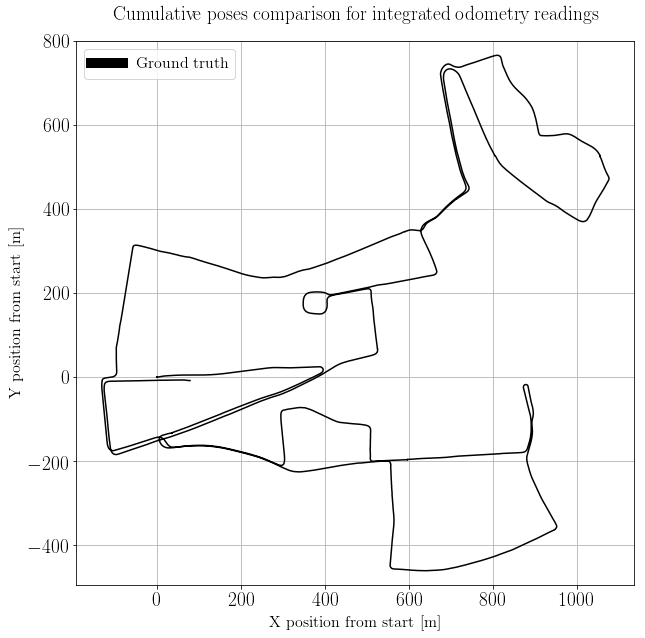

In [109]:
# get INS poses
INS_poses = []
pose = np.identity(4)
for i in range(len(INS_se3s)):
    pose = pose * INS_se3s[i]
    INS_poses.append(pose)

# get x,y coords
x_INS = [pose[0, 3] for pose in INS_poses]
y_INS = [pose[1, 3] for pose in INS_poses]
# downsample INS for figure rendering
x_INS_lite = x_INS[::10]
y_INS_lite = y_INS[::10]

plt.figure(figsize=(10,10)) # was 15,15
plt.plot(x_INS_lite,y_INS_lite,'-',color=colour_ins,markersize=1);
plt.axis('equal');
plt.title('Cumulative poses comparison for integrated odometry readings');
plt.xlabel('X position from start [m]');
plt.ylabel('Y position from start [m]');
line1, = plt.plot([],[],color=colour_ins,label='Ground truth',linewidth=10.0)

# plt.xlim(150, 200)
# plt.ylim(0,20)

plt.legend(handles=[line1],loc='best')
plt.savefig(dataset_path+"figs/filename_all_poses.pdf",bbox_inches='tight',pad_inches = 0)

(20000, 40000)

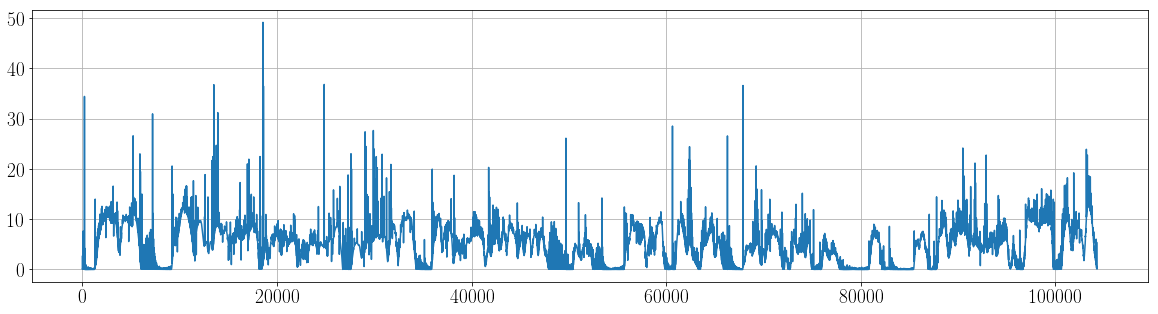

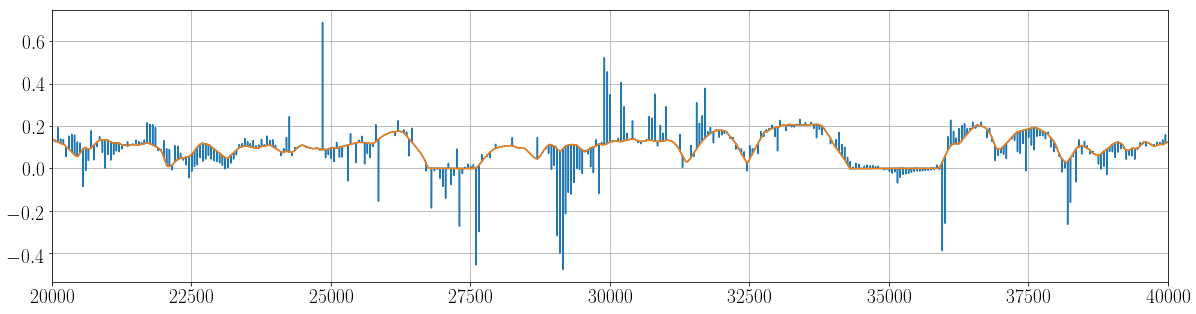

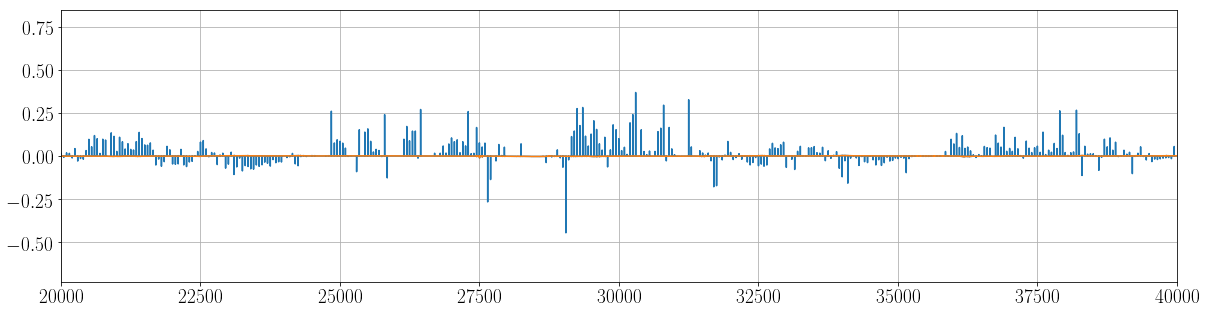

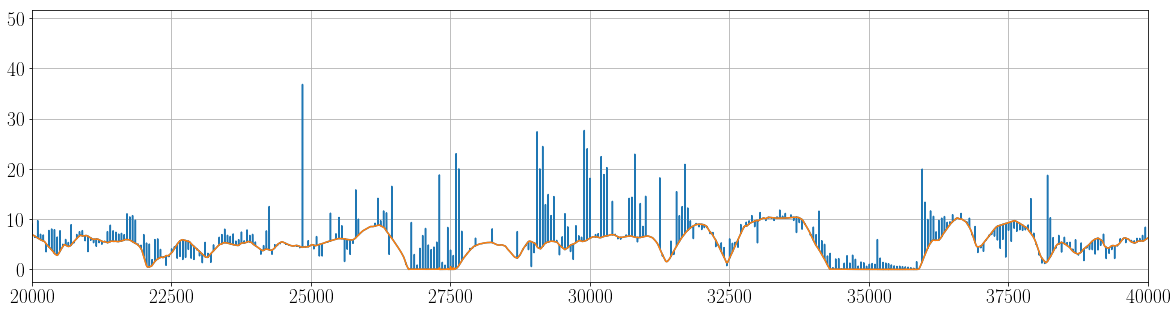

In [126]:
# get INS speeds
INS_speeds = []
INS_x_vals = []
INS_y_vals = []
filt_INS_se3s = []

# This is critical, otherwise we risk editing INS_se3s elements
for i in range(1,len(INS_se3s)):
    filt_INS_se3s.append((np.matrix(INS_se3s[i])))

deltatime_arr = []
for i in range(1,len(INS_timestamps)):
    INS_x_vals.append(INS_se3s[i][0,3])
    INS_y_vals.append(INS_se3s[i][1,3])
    # work out speed
    delta_time = (INS_timestamps[i] - INS_timestamps[i - 1]) / settings.TIMESTAMP_CONVERSION
    deltatime_arr.append(delta_time)
    se3 = INS_se3s[i]
    translation = se3[0:2, -1]
    incremental_distance = np.linalg.norm(translation)
    speed = incremental_distance / delta_time
    INS_speeds.append(speed)

plt.figure(figsize=(20,5))
plt.plot(INS_speeds);

plt.figure(figsize=(20,5))
plt.plot(INS_x_vals);
filt_INS_x_vals = signal.medfilt(INS_x_vals,5)
plt.plot(filt_INS_x_vals);
plt.xlim(20000,40000)

plt.figure(figsize=(20,5))
plt.plot(INS_y_vals);
filt_INS_y_vals = signal.medfilt(INS_y_vals,3)
plt.plot(filt_INS_y_vals);
plt.xlim(20000,40000)

filt_INS_speeds = []

for i in range(1,len(INS_timestamps)-1):
    # work out speed
    delta_time = (INS_timestamps[i] - INS_timestamps[i - 1]) / settings.TIMESTAMP_CONVERSION
    deltatime_arr.append(delta_time)
    translation = [filt_INS_x_vals[i],filt_INS_y_vals[i]]
    incremental_distance = np.linalg.norm(translation)
    speed = incremental_distance / delta_time
    filt_INS_speeds.append(speed)
    
plt.figure(figsize=(20,5))
plt.plot(INS_speeds);
plt.plot(filt_INS_speeds);
plt.xlim(20000,40000)


(20000, 40000)

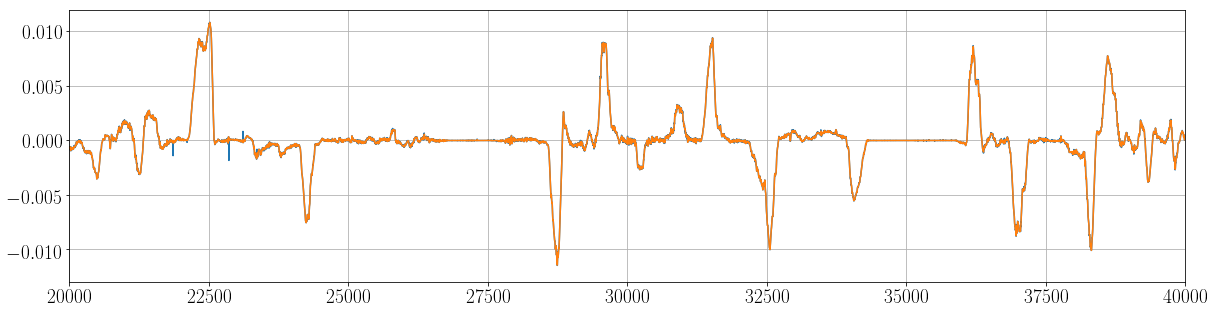

In [116]:
INS_thetas = [np.arctan2(x[1, 0], x[0, 0]) for x in INS_se3s]
filt_INS_thetas = signal.medfilt(INS_thetas,5)
plt.figure(figsize=(20,5))
plt.plot(INS_thetas)
plt.plot(filt_INS_thetas)
plt.xlim(20000,40000)

In [138]:
# Adjust se3s after filtering has been done
for i in range(len(filt_INS_se3s)):
    filt_INS_se3s[i][0,0] = np.cos(filt_INS_thetas[i])
    filt_INS_se3s[i][0,1] = -np.sin(filt_INS_thetas[i])
    filt_INS_se3s[i][1,0] = np.sin(filt_INS_thetas[i])
    filt_INS_se3s[i][1,1] = np.cos(filt_INS_thetas[i])


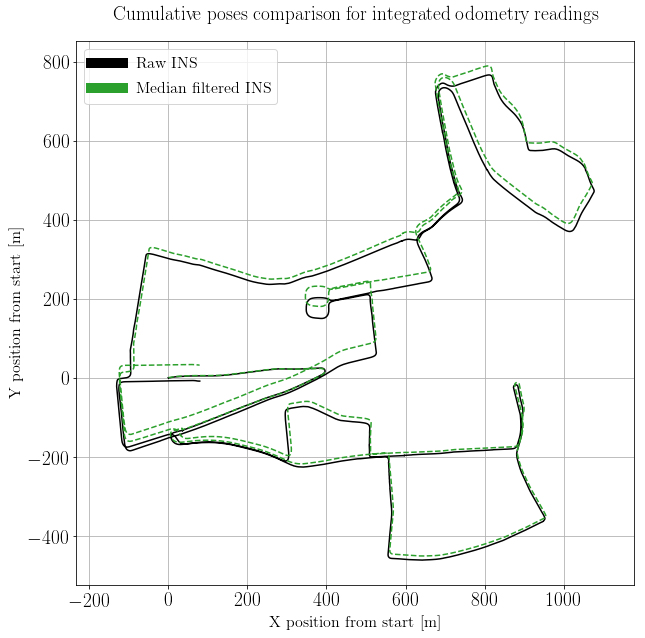

In [141]:
for i in range(len(filt_INS_x_vals)):
    filt_INS_se3s[i][0,3] = filt_INS_x_vals[i]
    filt_INS_se3s[i][1,3] = filt_INS_y_vals[i]

# get INS poses
INS_poses = []
pose = np.identity(4)
for i in range(len(INS_se3s)):
    pose = pose * INS_se3s[i]
    INS_poses.append(pose)

# get x,y coords
x_INS = [pose[0, 3] for pose in INS_poses]
y_INS = [pose[1, 3] for pose in INS_poses]
# downsample INS for figure rendering
x_INS_lite = x_INS[::10]
y_INS_lite = y_INS[::10]

# get filtered INS poses
INS_poses_filt = []
pose_filt = np.identity(4)
for i in range(len(filt_INS_se3s)):
    pose_filt = pose_filt * filt_INS_se3s[i]
    INS_poses_filt.append(pose_filt)

# get x,y coords
x_INS_filt = [pose_filt[0, 3] for pose_filt in INS_poses_filt]
y_INS_filt = [pose_filt[1, 3] for pose_filt in INS_poses_filt]
# downsample INS for figure rendering
x_INS_filt_lite = x_INS_filt[::10]
y_INS_filt_lite = y_INS_filt[::10]

plt.figure(figsize=(10,10)) # was 15,15
plt.plot(x_INS_lite,y_INS_lite,'-',color=colour_ins,markersize=1);
plt.plot(x_INS_filt_lite,y_INS_filt_lite,'--',color=colour_aux_2,markersize=1);
plt.axis('equal');
plt.title('Cumulative poses comparison for integrated odometry readings');
plt.xlabel('X position from start [m]');
plt.ylabel('Y position from start [m]');
line1, = plt.plot([],[],color=colour_ins,label='Raw INS',linewidth=10.0)
line2, = plt.plot([],[],color=colour_aux_2,label='Median filtered INS',linewidth=10.0)


# plt.xlim(150, 200)
# plt.ylim(0,20)

plt.legend(handles=[line1,line2],loc='best')
plt.savefig(dataset_path+"figs/filename_all_poses.pdf",bbox_inches='tight',pad_inches = 0)

(20000, 40000)

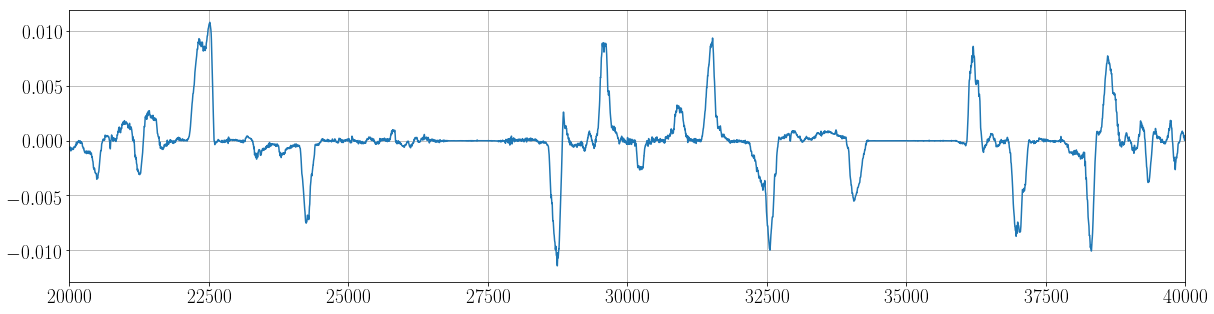

In [140]:
INS_thetas = [np.arctan2(x[1, 0], x[0, 0]) for x in filt_INS_se3s]
# filt_INS_thetas = signal.medfilt(INS_thetas,5)
plt.figure(figsize=(20,5))
plt.plot(INS_thetas)
# plt.plot(filt_INS_thetas)
plt.xlim(20000,40000)